In [1]:
%matplotlib inline
import numpy as np
import theano
import theano.tensor as tt
import sys
sys.path.insert(0, "../../..")
import pymc3 as pm

using gp modified version


In [2]:
def plot_cov(X, K):
    x = X.flatten()
    fig = plt.figure(figsize=(16,5))
    ax1 = fig.add_subplot(121)
    m = ax1.imshow(K, cmap="viridis"); plt.colorbar(m)
    ax2 = fig.add_subplot(122)
    ax2.plot(x, K[:,0], "k", lw=2, alpha=0.8)

# Some covariance functions / kernels

## Exponentiated Quadratic

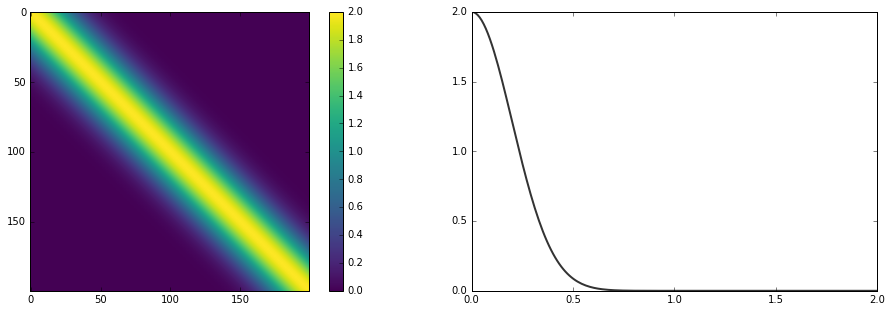

In [3]:
with pm.Model() as model:
    l = 0.2 
    tau = 2.0 
    cov_eq = tau * pm.gp.cov.ExpQuad(1, l)

X = np.linspace(0,2,200)[:,None]
K_eq = theano.function([], cov_eq.K(X))()

plot_cov(X, K_eq)

## Rational Quadratic

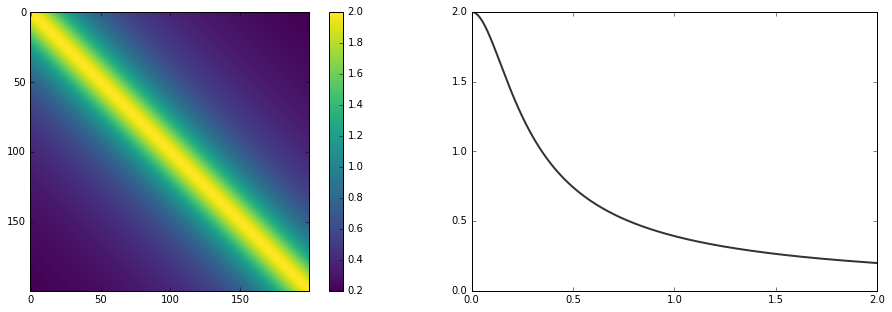

In [4]:
with pm.Model() as model:
    alpha=0.5
    cov_rq = tau * pm.gp.cov.RatQuad(1, l, alpha)

K_rq = theano.function([], cov_rq.K(X))()

plot_cov(X, K_rq)

## Exponential

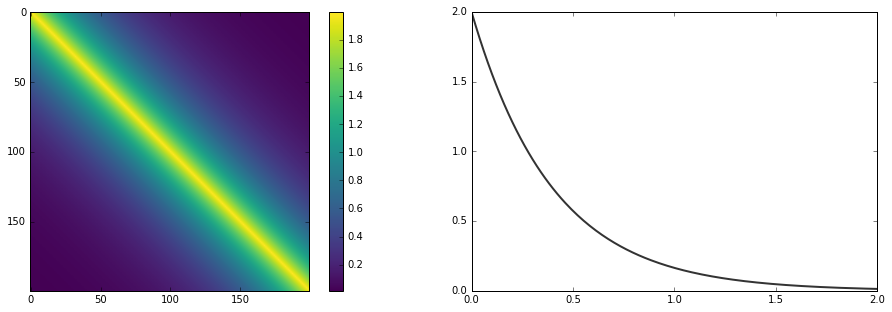

In [5]:
with pm.Model() as model:
    cov_exp = tau * pm.gp.cov.Exponential(1, l)

K_exp = theano.function([], cov_exp.K(X))()

plot_cov(X, K_exp)

## Matern 5/2

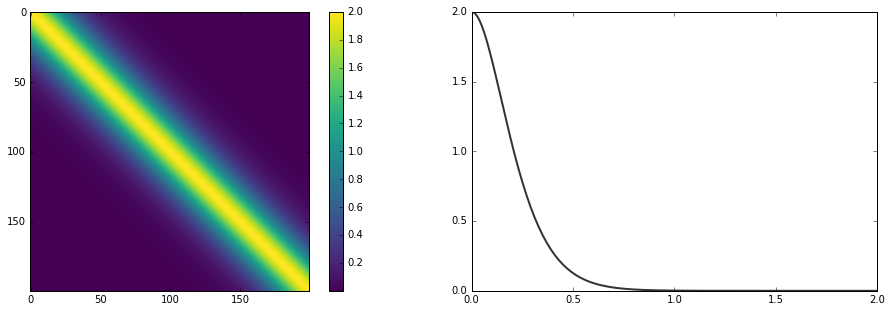

In [6]:
with pm.Model() as model:
    cov_m52 = tau * pm.gp.cov.Matern52(1, l)

K_m52 = theano.function([], cov_m52.K(X))()

plot_cov(X, K_m52)

## Matern 3/2

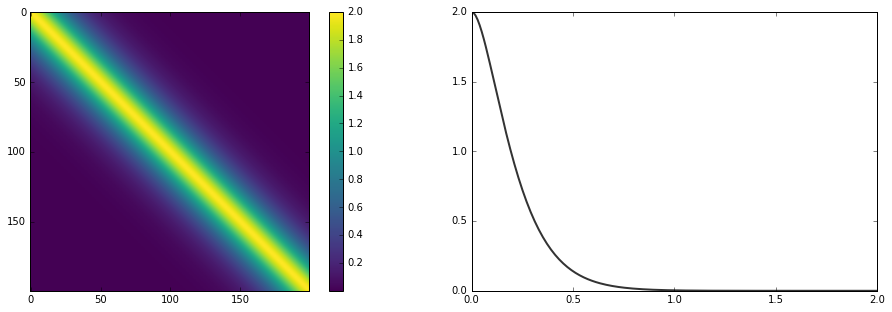

In [7]:
with pm.Model() as model:
    cov_m32 = tau * pm.gp.cov.Matern32(1, l)

K_m32 = theano.function([], cov_m32.K(X))()

plot_cov(X, K_m32)

# Cosine

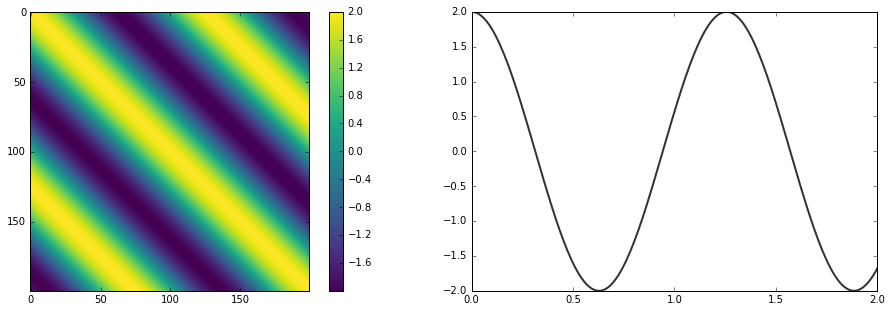

In [8]:
with pm.Model() as model:
    cov_cos = tau * pm.gp.cov.Cosine(1, l)

K_cos = theano.function([], cov_cos.K(X))()

plot_cov(X, K_cos)

# Linear

In [ ]:
center = 1
with pm.Model() as model:
    cov_lin = tau * pm.gp.cov.Linear(1, center)

K_lin = theano.function([], cov_lin.K(X))()

plot_cov(X, K_lin)